# Visualize Segformer decoder outputs

We'll process only one image through the Segformer without the segmentation head and visualize 64 outputs.

Load visualizaton methods:

In [17]:
import sys
sys.path.append('/tmp/share/repos/nenad/baseline')
from datasets.datasets import SN8Dataset
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.vis_utils import visualize_grid

def viz_rgb_image(image):
    raw_im = np.moveaxis(image, 0, -1) # now it is channels last
    raw_im = raw_im/np.max(raw_im)
    plt.imshow(raw_im)
    plt.show()
    
def viz_flood_mask(flood, preimage, postimage):
    combined_mask_cmap = colors.ListedColormap(['black', 'red', 'blue', 'purple', 'yellow'])
    if preimage is not None and postimage is not None:
        fig, axs = plt.subplots(1, 3, figsize=(24,8))
        ax=axs[0]
        ax.set_title("ground truth", fontsize=16)
        ax.imshow(flood,
                  interpolation='nearest', origin='upper',
                  cmap=combined_mask_cmap,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
        fig.suptitle('Flood Ground Truth and Pre-Event Imagery \n (1=non-flood building, 2=flood building, 3=non-flood road, 4=flood road)', fontsize=16)
        ax = axs[1]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        raw_im = np.moveaxis(preimage, 0, -1) # now it is channels last
        raw_im = raw_im/np.max(raw_im)
        ax.imshow(raw_im)
        flood = np.where(flood==0, np.nan, flood)
        ax=axs[1]
        ax.set_title("pre-event image and ground truth", fontsize=16)
        im = ax.imshow(flood,
                  interpolation='nearest', origin='upper',
                  cmap=combined_mask_cmap, alpha=0.6,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax=axs[2]
        ax.set_title("post-event image", fontsize=16)
        raw_im2 = np.moveaxis(postimage, 0, -1) # now it is channels last
        raw_im2 = raw_im2/np.max(raw_im2)
        ax.imshow(raw_im2)
        plt.show()
    else:
        plt.imshow(flood,
                  interpolation='nearest', origin='upper',
                  cmap=combined_mask_cmap,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5], combined_mask_cmap.N))
        plt.colorbar()
        plt.show()
    
def viz_roadspeed_mask(roadspeed, image=None):
    combined_mask_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red',
                                                'purple', 'orange', 'yellow', 'brown',
                                                'pink'])
    if image is not None:
        fig, axs = plt.subplots(1, 2, figsize=(16,8))
        ax=axs[0]
        ax.imshow(roadspeed, cmap=combined_mask_cmap, interpolation='nearest', origin='upper',
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
        
        fig.suptitle('Road Speed Ground Truth and Pre-Event Imagery', fontsize=16)
        ax = axs[1]
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)

        raw_im = np.moveaxis(image, 0, -1) # now it is channels last
        raw_im = raw_im/np.max(raw_im)
        ax.imshow(raw_im)
        roadspeed = np.where(roadspeed==0, np.nan, roadspeed)
        ax=axs[1]
        im = ax.imshow(roadspeed, cmap=combined_mask_cmap, interpolation='nearest', origin='upper', alpha=0.6,
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
        fig.colorbar(im, cax=cax, orientation='vertical')
        plt.show()
    else:
        plt.imshow(roadspeed, cmap=combined_mask_cmap, interpolation='nearest', origin='upper',
                  norm=colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], combined_mask_cmap.N))
        plt.colorbar()
        plt.show()

Create a dataset from one image:

loaded 1 image filepaths
filename:  /tmp/share/data/spacenet8/Louisiana-East_Training_Public/PRE-event/10300100AF395C00_2_16_51.tif
pre-event image


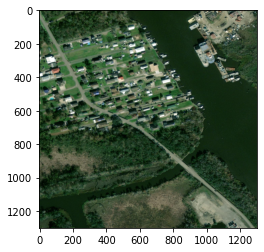

post-event image


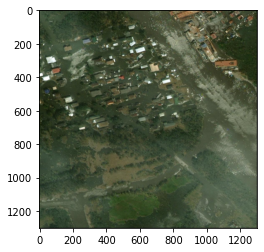

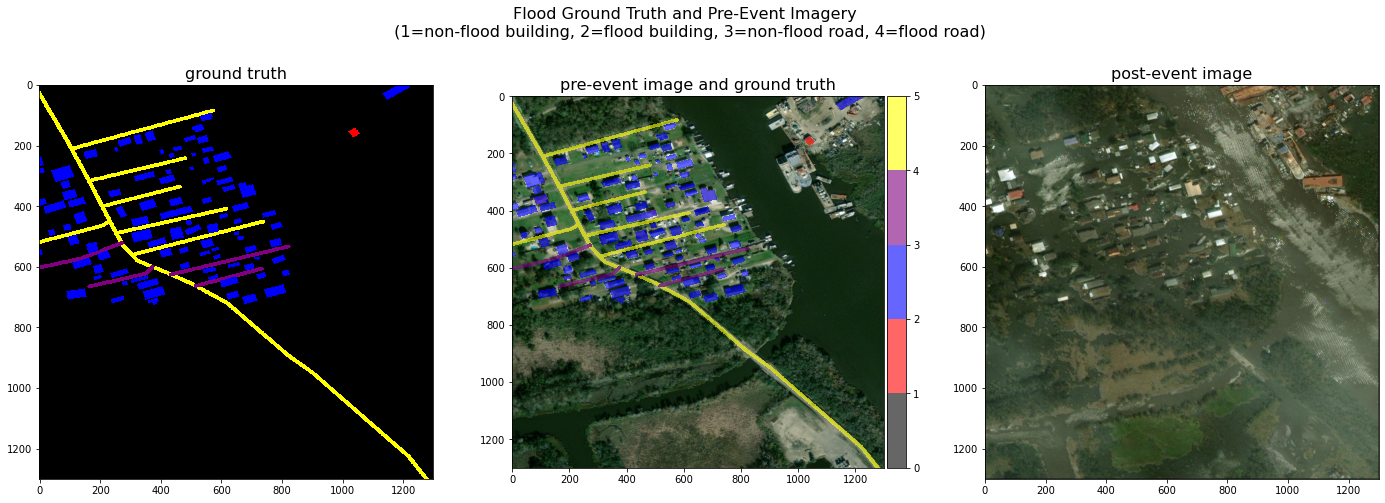

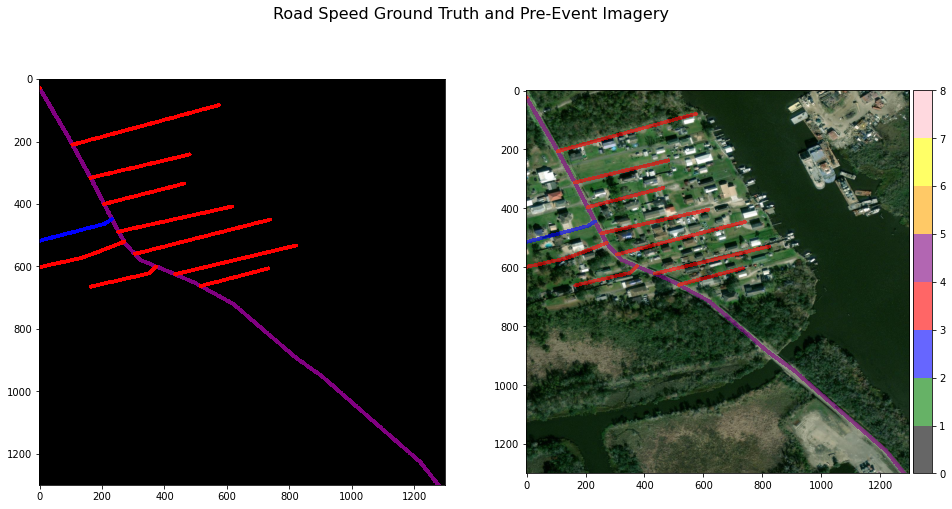

In [9]:
import numpy as np
import torch

input_csv = "/tmp/share/data/spacenet8/nb_just_one.csv"
n_to_visualize = 1
dataset = SN8Dataset(input_csv,
                     data_to_load=["preimg","postimg", "building", "road", "roadspeed", "flood"],
                     img_size=(1300,1300))
batch_size=1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

for i, data in enumerate(dataloader):
    preimg, postimg, building, road, roadspeed, flood = data # data from here is shape (batch_size, channels, height, width)
    # preimg, postimg are shape=(batch_size, 3, 1024, 1024)
    # building labels are shape=(batch_size, 1, 1024, 1024)
    # road labels are shape=(batch_size, 1, 1024, 1024)
    # roadspeed labels are shape=(batch_size, 8, 1024, 1024)
    # flood labels are shape=(batch_size, 4, 1024, 1024)

    preimg = preimg.cpu().numpy()[0]
    postimg = postimg.cpu().numpy()[0]
    flood = flood.cpu().numpy()[0]
    building = building.cpu().numpy()[0]
    road = road.cpu().numpy()[0]
    roadspeed = roadspeed.cpu().numpy()[0]

    flood_shape = flood.shape # (4, 1024, 1024).
    # let's add 0th layer as a background
    tempfld = np.zeros(shape=(flood_shape[0]+1,flood_shape[1],flood_shape[2]))
    tempfld[1:5] = flood  
    flood = tempfld
    flood = np.argmax(flood, axis=0)
    
    roadspeed_shape = roadspeed.shape
    # same as for buildings, we add background as 0th layer
    tempspeed = np.zeros(shape=(roadspeed_shape[0]+1,roadspeed_shape[1],roadspeed_shape[2]))
    tempspeed[1:] = roadspeed
    roadspeed = tempspeed
    roadspeed = np.argmax(roadspeed, axis=0)

    print("filename: ", dataset.get_image_filename(i))
    print("pre-event image")
    viz_rgb_image(preimg)
    print("post-event image")
    viz_rgb_image(postimg)
    viz_flood_mask(flood, preimg, postimg)
    viz_roadspeed_mask(roadspeed, preimg)

    if i == n_to_visualize-1:
        break

Create a model with no segmentation head:

In [12]:
import models.other.segformer as segformer
model = segformer.Segformer_b0_no_head(num_classes=[1,8], num_channels=3)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_he

Initialize from pretrained weights...


In [15]:
# tt = torch.rand((1, 3, 1300, 1300))
tt = torch.tensor(preimg).unsqueeze(0)
tt.shape

torch.Size([1, 3, 1300, 1300])

In [20]:
bldgs_filters, roads = model(tt)
bldgs_filters.shape

torch.Size([1, 64, 325, 325])

In [32]:
x = bldgs_filters.permute((1,2,3,0))
x = x.detach().numpy()

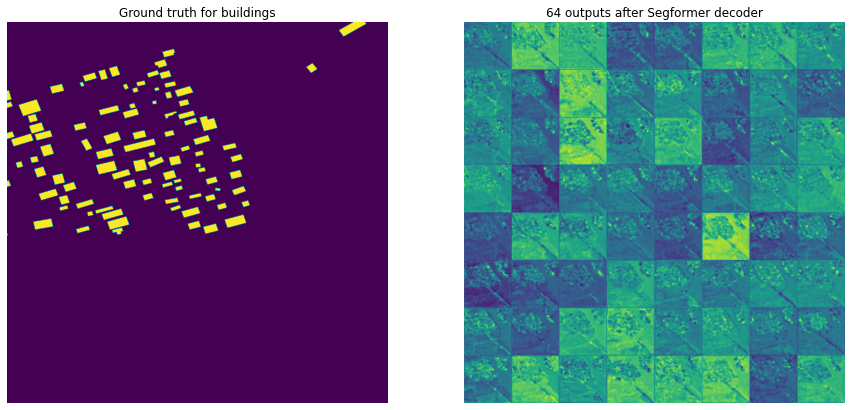

In [62]:
plt.subplot(121)
image= building
raw_im = np.moveaxis(image, 0, -1) # now it is channels last
raw_im = raw_im/np.max(raw_im)
plt.imshow(raw_im)
plt.axis('off')
plt.title('Ground truth for buildings')

plt.subplot(122)
grid = visualize_grid(x, ubound=255.0, padding=1)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('64 Segformer outputs (after decoder)')
plt.show()
